In [69]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
!unzip gdrive/My\ Drive/image_classification.zip 

Archive:  gdrive/My Drive/image_classification.zip
replace image_classification/1111.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
pip install fastai==1.0.61

In [72]:
import torch
#from fastai.vision import *
from fastai.vision import Path,get_image_files,open_image,get_transforms,ImageDataBunch,imagenet_stats,cnn_learner,models,ClassificationInterpretation
import pandas as pd
import numpy as np
import warnings
from fastai.metrics import error_rate
from fastai.vision import Path

warnings.filterwarnings('ignore')
np.random.seed(2)

from fastai import *
from fastai.vision import *
from fastai.core import *

In [73]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [74]:
base_path = Path('image_classification')
images_path = base_path/'images'
base_path.ls()

[PosixPath('image_classification/images'),
 PosixPath('image_classification/Training_labels'),
 PosixPath('image_classification/1111.jpg'),
 PosixPath('image_classification/3089.jpg'),
 PosixPath('image_classification/styles.csv'),
 PosixPath('image_classification/faashion_img.ipynb'),
 PosixPath('image_classification/1929.jpg'),
 PosixPath('image_classification/fashion_image_classify.ipynb'),
 PosixPath('image_classification/34258.jpg')]

In [102]:
df_fine_tuned = pd.read_csv(base_path/'Training_labels/top_65_catagory.csv')
df_fine_tuned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29324 entries, 0 to 29323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    29324 non-null  object
 1   label   29324 non-null  object
dtypes: object(2)
memory usage: 458.3+ KB


In [76]:
df_fine_tuned.head()

,name,label
0,39386.jpg,Jeans-Men-Bottomwear-Apparel
1,21379.jpg,Track Pants-Men-Bottomwear-Apparel
2,53759.jpg,Tshirts-Men-Topwear-Apparel
3,1855.jpg,Tshirts-Men-Topwear-Apparel
4,30805.jpg,Shirts-Men-Topwear-Apparel


In [77]:
#Printing images that don't exist from the dataframe
invalid_img = []
for idx,value in enumerate(df_fine_tuned.name):
    path = images_path/str(value)
    if not path.is_file():
        invalid_img.append(idx)
        print(idx,path)
invalid_img

[]

In [78]:
#Printing distinct catagories
len(df_fine_tuned.label.unique())

65

In [79]:
df_fine_tuned.groupby('label')['name'].count().nlargest(100)

label
Tshirts-Men-Topwear-Apparel                         4223
Shirts-Men-Topwear-Apparel                          2289
Men-Shoes-Footwear                                  2286
Kurtas-Women-Topwear-Apparel                        1586
Sports Shoes-Footwear                               1579
                                                    ... 
Shorts-Boys-Bottomwear-Apparel                        46
Night suits-Men-Loungewear and Nightwear-Apparel      43
Laptop Bag-Unisex-Bags-Accessories                    43
Backpacks-Men-Bags-Accessories                        42
Jackets-Women-Topwear-Apparel                         38
Name: name, Length: 65, dtype: int64

Shirts-Men-Topwear-Apparel


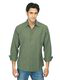

In [80]:
print(df_fine_tuned['label'][4])
open_image(base_path/'images'/df_fine_tuned['name'][4])

In [81]:
df_fine_tuned

,name,label
0,39386.jpg,Jeans-Men-Bottomwear-Apparel
1,21379.jpg,Track Pants-Men-Bottomwear-Apparel
2,53759.jpg,Tshirts-Men-Topwear-Apparel
3,1855.jpg,Tshirts-Men-Topwear-Apparel
4,30805.jpg,Shirts-Men-Topwear-Apparel
...,...,...
29319,13496.jpg,Tshirts-Men-Topwear-Apparel
29320,12544.jpg,Tshirts-Women-Topwear-Apparel
29321,42234.jpg,Shirts-Women-Topwear-Apparel
29322,17036.jpg,Men-Shoes-Footwear


In [82]:
data_fine_tuned = ImageDataBunch.from_df(images_path, df_fine_tuned, ds_tfms=False,size=60, bs=64).normalize(imagenet_stats)

In [83]:
learn = create_cnn(data_fine_tuned, models.resnet34, metrics=accuracy)

In [84]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.577173,1.218748,0.658595,00:32
1,1.108074,0.860262,0.730389,00:31
2,0.852773,0.754682,0.761085,00:23
3,0.687321,0.706703,0.769611,00:23


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


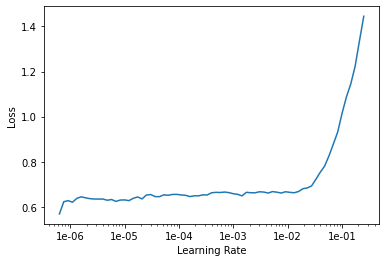

In [85]:
learn.lr_find()
learn.recorder.plot()

In [86]:
learn.unfreeze()

In [87]:
learn.fit_one_cycle(1, max_lr=slice(1e-06,1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.637641,0.603433,0.802183,00:35


In [88]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_fine_tuned.valid_ds)==len(losses)==len(idxs)

interp.most_confused(min_val=2)

[('Sports Shoes-Footwear', 'Men-Shoes-Footwear', 58),
 ('Tshirts-Women-Topwear-Apparel', 'Shirts-Women-Topwear-Apparel', 48),
 ('Watches-Women-Watches-Accessories', 'Watches-Men-Watches-Accessories', 37),
 ('Men-Shoes-Footwear', 'Sports Shoes-Footwear', 36),
 ('Shirts-Women-Topwear-Apparel', 'Kurtas-Women-Topwear-Apparel', 36),
 ('Shirts-Women-Topwear-Apparel', 'Tshirts-Women-Topwear-Apparel', 34),
 ('Casual Shoes-Unisex-Shoes-Footwear', 'Men-Shoes-Footwear', 27),
 ('Kurtas-Women-Topwear-Apparel', 'Shirts-Women-Topwear-Apparel', 24),
 ('Watches-Men-Watches-Accessories', 'Watches-Women-Watches-Accessories', 24),
 ('Kurtis-Women-Topwear-Apparel', 'Kurtas-Women-Topwear-Apparel', 23),
 ('Tshirts-Men-Topwear-Apparel', 'Shirts-Men-Topwear-Apparel', 22),
 ('Casual Shoes-Women-Shoes-Footwear', 'Men-Shoes-Footwear', 18),
 ('Shirts-Women-Topwear-Apparel', 'Tshirts-Men-Topwear-Apparel', 18),
 ('Kurtis-Women-Topwear-Apparel', 'Shirts-Women-Topwear-Apparel', 16),
 ('Watches-Unisex-Watches-Accessori

In [111]:
#Viewing top losses interpreted from the model
#interp.plot_top_losses(4, figsize=(15,6))

Jeans-Men-Bottomwear-Apparel


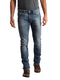

In [122]:
#Testing a image
print(df_fine_tuned['label'][8948])
test = open_image(base_path/'images'/df_fine_tuned['name'][8948])
test

In [120]:
#Running inference
learn.predict(test)

(Category tensor(19),
 tensor(19),
 tensor([3.6732e-08, 2.3225e-07, 3.9777e-08, 3.1521e-08, 2.4532e-06, 1.2124e-07,
         2.3871e-08, 1.2561e-08, 1.1330e-08, 9.6072e-09, 4.5247e-08, 1.9457e-07,
         1.5139e-08, 2.8338e-08, 2.7058e-08, 1.2069e-08, 1.4899e-09, 2.5683e-07,
         1.6308e-07, 9.9708e-01, 1.3989e-03, 4.5192e-07, 3.0539e-06, 3.7388e-06,
         8.7186e-07, 3.8528e-08, 1.4310e-06, 2.2692e-08, 9.2855e-07, 2.7590e-06,
         2.4267e-06, 1.0633e-08, 9.2422e-09, 8.3589e-06, 4.7603e-08, 2.4733e-06,
         1.9993e-07, 8.2897e-08, 2.5379e-06, 3.4351e-07, 4.0960e-07, 5.1331e-07,
         1.4364e-07, 3.8260e-07, 1.5908e-07, 4.4495e-08, 1.2144e-07, 4.5326e-08,
         3.4406e-07, 3.1728e-08, 8.0602e-07, 5.5032e-04, 4.9944e-05, 6.9030e-04,
         1.9611e-04, 2.2209e-09, 1.4289e-07, 2.2350e-08, 2.7683e-08, 9.0616e-08,
         3.9588e-09, 2.0839e-07, 1.3429e-07, 1.0889e-07, 9.4392e-09]))

In [121]:
data_fine_tuned.classes[19]

'Jeans-Men-Bottomwear-Apparel'

In [92]:
#list of labels 
data_fine_tuned.classes

['Backpacks-Men-Bags-Accessories',
 'Backpacks-Unisex-Bags-Accessories',
 'Belts-Men-Belts-Accessories',
 'Belts-Women-Belts-Accessories',
 'Capris-Women-Bottomwear-Apparel',
 'Caps-Men-Headwear-Accessories',
 'Caps-Unisex-Headwear-Accessories',
 'Casual Shoes-Unisex-Shoes-Footwear',
 'Casual Shoes-Women-Shoes-Footwear',
 'Clutches-Women-Bags-Accessories',
 'Dresses-Girls-Dress-Apparel',
 'Duffel Bag-Unisex-Bags-Accessories',
 'Flip Flops-Men-Flip Flops-Footwear',
 'Flip Flops-Unisex-Flip Flops-Footwear',
 'Flip Flops-Women-Flip Flops-Footwear',
 'Handbags-Unisex-Bags-Accessories',
 'Handbags-Women-Bags-Accessories',
 'Jackets-Men-Topwear-Apparel',
 'Jackets-Women-Topwear-Apparel',
 'Jeans-Men-Bottomwear-Apparel',
 'Jeans-Women-Bottomwear-Apparel',
 'Kurta Sets-Women-Apparel Set-Apparel',
 'Kurtas-Men-Topwear-Apparel',
 'Kurtas-Women-Topwear-Apparel',
 'Kurtis-Women-Topwear-Apparel',
 'Laptop Bag-Unisex-Bags-Accessories',
 'Leggings-Women-Bottomwear-Apparel',
 'Men-Shoes-Footwear',
 'N

In [114]:
#save model as pytorch
learn.save('Fashion_model-fine_tuned')

In [113]:
#Saving model as binary format
learn.path = Path("gdrive/MyDrive/Saved_model")
learn.export()

In [116]:
#Saving the label as csv file
labels = pd.DataFrame(data={"labels": data_fine_tuned.classes})
labels.to_csv("labels.csv", sep=',',index=False,header=False)

In [115]:
learn.path

PosixPath('gdrive/MyDrive/Saved_model')

In [117]:
learn.export('saved_model.pkl')

In [101]:
%store labels

Stored 'labels' (DataFrame)
